# Wildfire Fire Detection from Satellite Imagery 

## Imported Libraries

In [1]:
#Import Libraries
import os
import time
import pandas as pd
import numpy as np
import ray
import cv2 
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from tensorflow.keras import layers
import matplotlib.pyplot as plt

## User Defined Functions

### Function to Load Image

In [2]:
#Function to Load image and visualize it
# Load the image with OpenCV
def load_image(imagePath):
    """
    Loads an image from a path, plots it and returns a NumPy array.

    Args:
        imagePath (str): Path to the image file.

    Returns:
        np.ndarray: The loaded image as a NumPy array.
    """

    start_time = time.time()

    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(20,20))
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    return image

### Function to Tile Image

In [3]:
# Tile Image 
@ray.remote
def tile_image(height, width, overlap):
    '''
    Decription : A function to tile an image based on a specified length and width,
                    define an overlap and loop through it to append to the tile array
    Param:int : height
          int : width
          int : overlap
    Returns : returns an array of tiles
    '''
    start_time = time.time()
    tiles = []
    ## Define the tile size
    tile_size = (height, width)

    # Calculate the number of tiles in each dimension
    num_tiles_height = height // tile_size[0]
    num_tiles_width = width // tile_size[1]
    
    # Define the stride (amount of overlap)
    overlap = 20  # Adjust this value based on your desired overlap amount

    # Iterate over the tiles and extract each hxw patch with overlap
    tiles = []
    for i in range(0, image.shape[0] - tile_size[0] + 1, overlap):
        for j in range(0, image.shape[1] - tile_size[1] + 1, overlap):
            tile = image[i : i + tile_size[0], j : j + tile_size[1]]
            tiles.append(tile)
    print(f"Tiling time: {time.time() - start_time:.2f} seconds")
    return tiles
    

### Function to Normalize Image tiles to [0, 1]

In [4]:
def normalize_image(image):
    # Convert to NumPy array if needed
    image = np.asarray(image, dtype=np.float64)

    # Min-max normalization to scale values between 0 and 1
    min_value = np.min(image)
    max_value = np.max(image)

    normalized_image = (image - min_value) / (max_value - min_value + 1e-20)  # Adding a small value to avoid division by zero

    return normalized_image

## Load Satellite Imagery

### Image path specification

In [5]:
#Specify Image path
imagePath = 'images/fire.jpg'

### Load image using loadImg(imagePath)

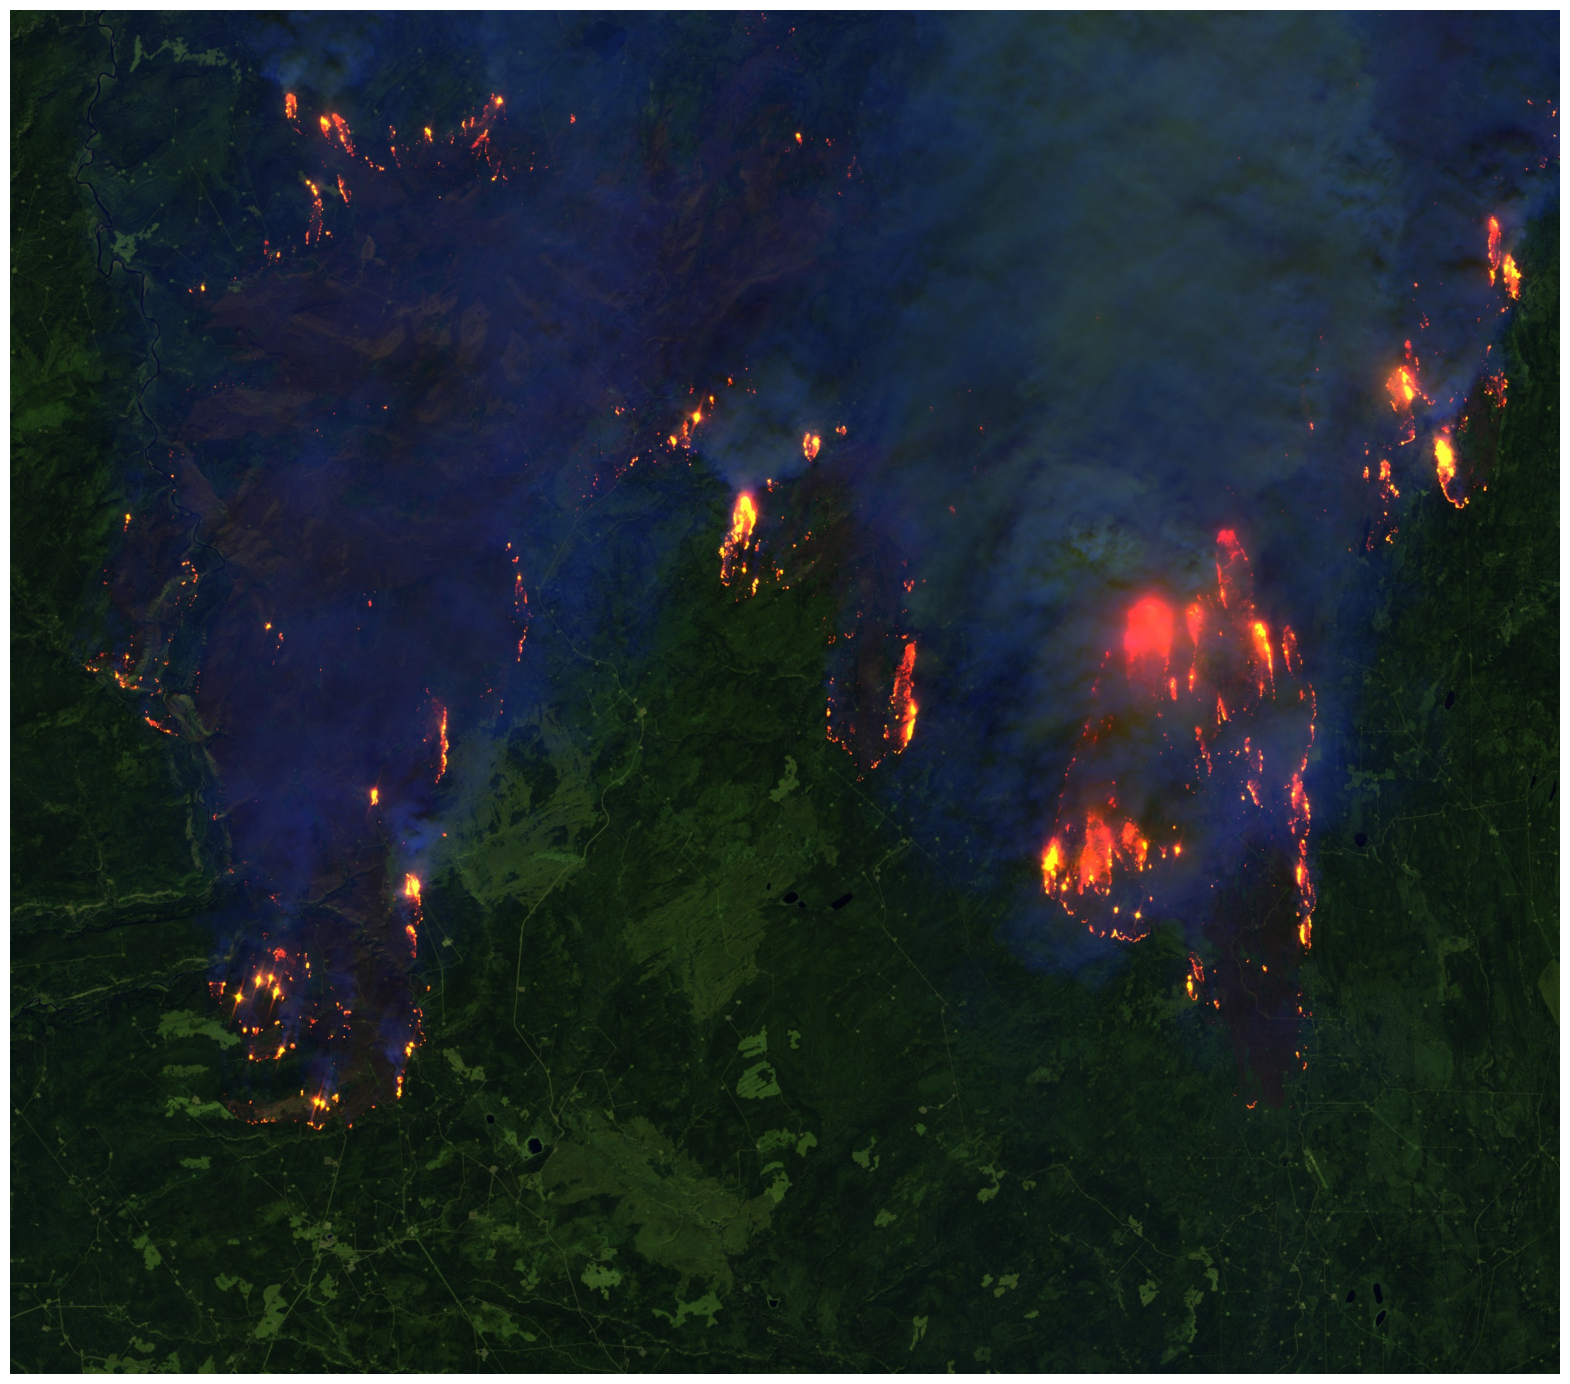

In [6]:
image = load_image(imagePath)

In [7]:
image.dtype

dtype('uint8')

### Image dimention

In [8]:
## Image shape
print(f"Image shape : {image.shape}")

Image shape : (2200, 2500, 3)


### View Image matrix

In [9]:
# Visualize orignal Image matrix
print(image)

[[[15 36 21]
  [15 36 19]
  [16 37 20]
  ...
  [17 32 73]
  [17 32 73]
  [16 31 72]]

 [[18 39 24]
  [17 38 21]
  [18 39 20]
  ...
  [16 31 72]
  [16 31 72]
  [16 31 72]]

 [[21 42 25]
  [19 40 23]
  [19 40 21]
  ...
  [16 31 70]
  [16 31 70]
  [16 31 70]]

 ...

 [[17 30 20]
  [16 29 19]
  [15 28 18]
  ...
  [16 30 17]
  [15 29 16]
  [15 29 16]]

 [[20 34 21]
  [17 31 18]
  [16 30 17]
  ...
  [17 31 18]
  [16 30 17]
  [14 28 15]]

 [[22 36 21]
  [19 33 18]
  [18 32 19]
  ...
  [18 32 19]
  [16 30 17]
  [14 28 15]]]


## Image Preprocessing

### Normalize image

In [10]:
normalized_image = normalize_image(image)

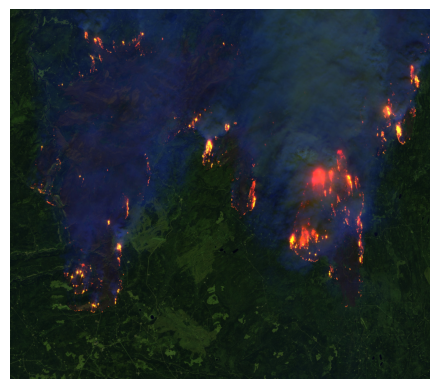

In [11]:
plt.imshow(normalized_image)
plt.axis('off')  # Remove axis ticks and labels
plt.show()

In [ ]:
cv2.imwrite("images/normalized_false_image.jpg", normalized_image)

In [ ]:
# Visualize normalized Image matrix
print(normalized_image)

In [ ]:
### Visualize original vs normalized image

# Read the original and cropped images
original_image = cv2.imread("images/fire.jpg")
normalized_image = cv2.imread("images/normalized_image.jpg")

# Display the images using Matplotlib
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the original image
ax1.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image')
ax1.axis('off')

# Plot the cropped image
ax2.imshow(cv2.cvtColor(normalized_image, cv2.COLOR_BGR2RGB))
ax2.set_title('normalized_image')
ax2.axis('off')

plt.show()

### Thresholding to isolate fire regions

In [ ]:
def threshold_binary_mask(false_color_composite, threshold_values):
    # Apply thresholding based on the specified threshold values
    fire_mask = np.zeros_like(false_color_composite[:, :, 0], dtype=np.uint8)
    for i, threshold in enumerate(threshold_values):
        fire_mask[false_color_composite[:, :, i] > threshold] = 255

    # Convert to binary mask (1 for fire, 0 for no fire)
    binary_mask = (fire_mask > 0).astype(np.uint8)

    return binary_mask

In [ ]:
# Load the false-color composite image
false_color_composite = cv2.imread("images/fire.jpg")

# Specify the threshold values for each band
threshold_values = [100, 150, 200]  # Adjust these threshold values based on your specific image characteristics

# Generate the binary mask using thresholding
binary_mask = threshold_binary_mask(false_color_composite, threshold_values)

# Save the binary mask as an image
cv2.imwrite("images/binary_mask.jpg", binary_mask)

### Tile image 

In [ ]:
# Tile images
height = 1024
width = 1024
overlap = 0
tiles = tile_image.remote(height, width, overlap)

In [ ]:
tiles = ray.get(tiles)

In [ ]:
len(tiles)

### Tile Dimention 

In [ ]:
## Tile shape
print(f"Image shape : {tiles[1000].shape}")

### View number of tiles in tiles[ ]

In [ ]:
# Number of items in list
print(len(tiles))

### Visualize Matrix of any random tile, tiles[n] where n = arrIDX

In [ ]:
print(tiles[10])

### Plot  any random tile, tiles[n] where n = arrIDX

In [ ]:
#Visualize the first tile
# Display the image using matplotlib
plt.imshow(tiles[2600])
plt.axis('off')  # Remove axis ticks and labels
plt.show()

In [ ]:
print(f"tile shape : {tiles[0].shape}")

### Normalize each tile to values [0, 1]

In [ ]:
normalized_tiles = normalize_tiles(tiles, smooth=1e-20)

### Randomize / Shuffle image